# Decision Trees

- Reading:
    Geron, chapter 6

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

- Like SVMs, *Decision Trees* are versatile Machine Learning algorithms that can perform
both classification and regression tasks, and even multioutput tasks.
- Decision Trees are also the fundamental components of *Random Forests*, which are among the most powerful Machine Learning algorithms available
today.

### Training and Visualizing a Decision Tree

- To understand Decision Trees, let’s just build one and take a look at how it makes predictions.
- The following code trains a `DecisionTreeClassifier` on the iris dataset.

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualize the trained Decision Tree by first using the `export_graphviz()`
method to output a graph definition file called iris_tree.dot:

In [4]:
!pip install graphviz

In [18]:
# graphviz requires double installation
# 1. pip install graphviz
# 2. download and install the binaries (set the system path to the bin subfolder)

from graphviz import Source
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
        tree_clf,
        out_file=None,
        #out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

In [19]:
iris.feature_names[2:]
iris.target_names

['petal length (cm)', 'petal width (cm)']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [20]:
print(dot_data)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="petal length (cm) <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa", fillcolor="#ffffff"] ;
1 [label="gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa", fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor", fillcolor="#ffffff"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor", fillcolor="#4de88e"] ;
2 -> 3 ;
4 [label="gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica", fillcolor="#843de6"] ;
2 -> 4 ;
}


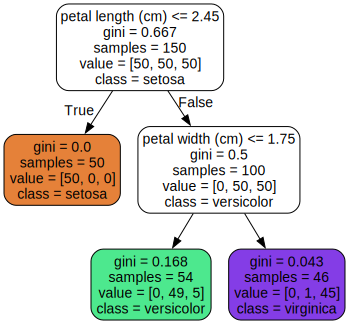

In [21]:
Source(dot_data, format="png")

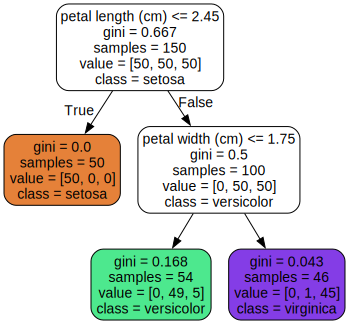

In [15]:
Source.from_file("iris_tree.dot")

- It is possible to convert .dot images to .png or .pdf using the dot command-line tool
`dot -Tpng iris_tree.dot -o iris_tree.png`

### Making Predictions

How does the tree represented in the figure make predictions?

- Suppose you find an iris flower and you want to classify it. You start at the **root node** (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a **leaf node** (i.e., it does not have any children nodes), so it does not ask any questions: you can simply look at the predicted class for that node and the Decision Tree predicts that your flower is an Iris-Setosa (class=setosa).

- Now suppose you find another flower, but this time the petal length is greater than 2.45 cm. You must move down to the root’s right child node (depth 1, right), which is not a leaf node, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris-Versicolor (depth 2, left). If not, it is likely an Iris-Virginica (depth 2, right).

- A node’s `samples` attribute counts how many training instances it applies to. For
example, 100 training instances have a petal length greater than 2.45 cm (depth 1,
right), among which 54 have a petal width smaller than 1.75 cm (depth 2, left).
- A node’s `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris-Setosa, 1 Iris-
Versicolor, and 45 Iris-Virginica.
- Finally, a node’s `gini` attribute measures its **impurity**:
    - a node is “pure” (gini=0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris-Setosa training instances, it is pure and its gini score is 0
    
    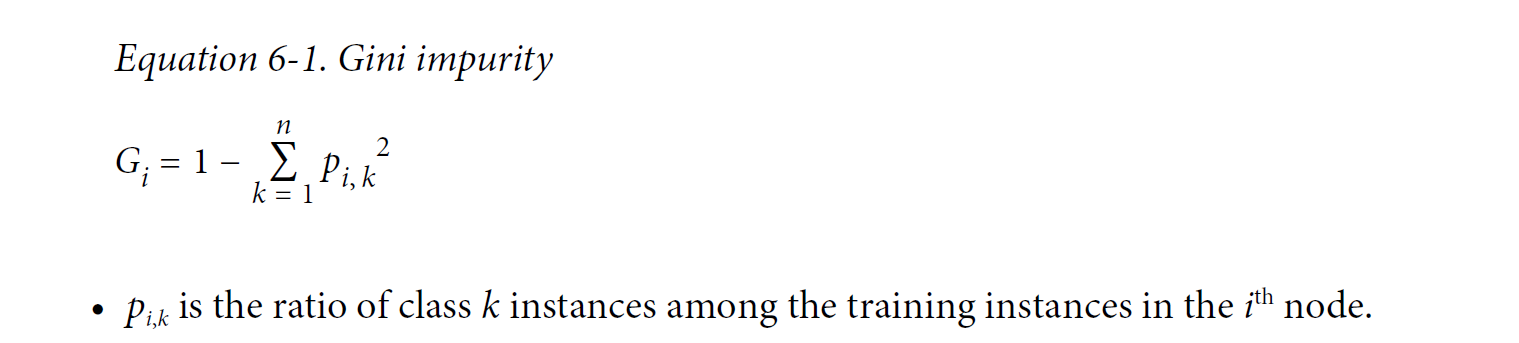

In [35]:
# Versicolor Gini
1 - (49/54)**2 - (5/54)**2

0.1680384087791495

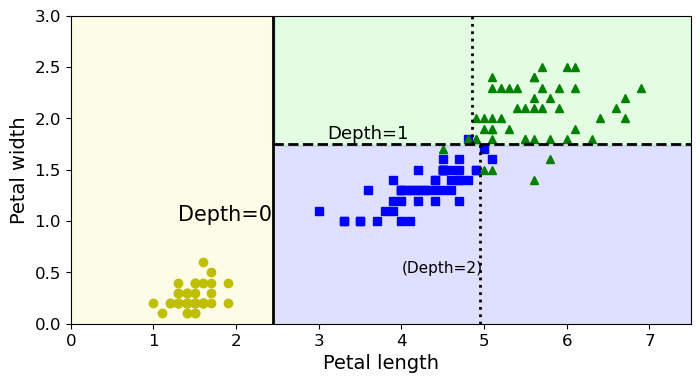

In [22]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3],
                           iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap);
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8);
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa");
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor");
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica");
        plt.axis(axes);
    if iris:
        plt.xlabel("Petal length", fontsize=14);
        plt.ylabel("Petal width", fontsize=14);
    else:
        plt.xlabel(r"$x_1$", fontsize=18);
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0);
    if legend:
        plt.legend(loc="lower right", fontsize=14);

plt.figure(figsize=(8, 4));
plot_decision_boundary(tree_clf, X, y);
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2);
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2);
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2);
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2);
plt.text(1.3, 1.0, "Depth=0", fontsize=15);
plt.text(3.1, 1.80, "Depth=1", fontsize=13);
plt.text(4.0, 0.5, "(Depth=2)", fontsize=11);

plt.show();

The figure shows this Decision Tree’s decision boundaries.

- The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm.
- Since the left area is pure (only Iris-Setosa), it cannot be split any further.
- However, the right area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line).
- Since `max_depth` was set to 2, the Decision Tree stops right there. However, if you set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).

### Estimating Class Probabilities

- A Decision Tree can also estimate the probability that an instance belongs to a particular class $k$:
    - it traverses the tree to find the leaf node for this instance
    - it returns the ratio of training instances of class $k$ in this node.

- For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide.
    - The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor (49/54), and 9.3% for Iris-Virginica (5/54).
    - If you ask it to predict the class, it should output Iris-Versicolor (class 1) since it has the highest probability.

In [23]:
tree_clf.predict([[5, 1.5]])

array([1])

In [24]:
tree_clf.predict_proba([[5, 1.5]]) * 100

array([[ 0.        , 90.74074074,  9.25925926]])

### The CART Training Algorithm

- Scikit-Learn uses the **Classification And Regression Tree (CART)** algorithm to train
Decision Trees.
- The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature $k$ and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). - How does it choose $k$ and $t_k$? It searches for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size).

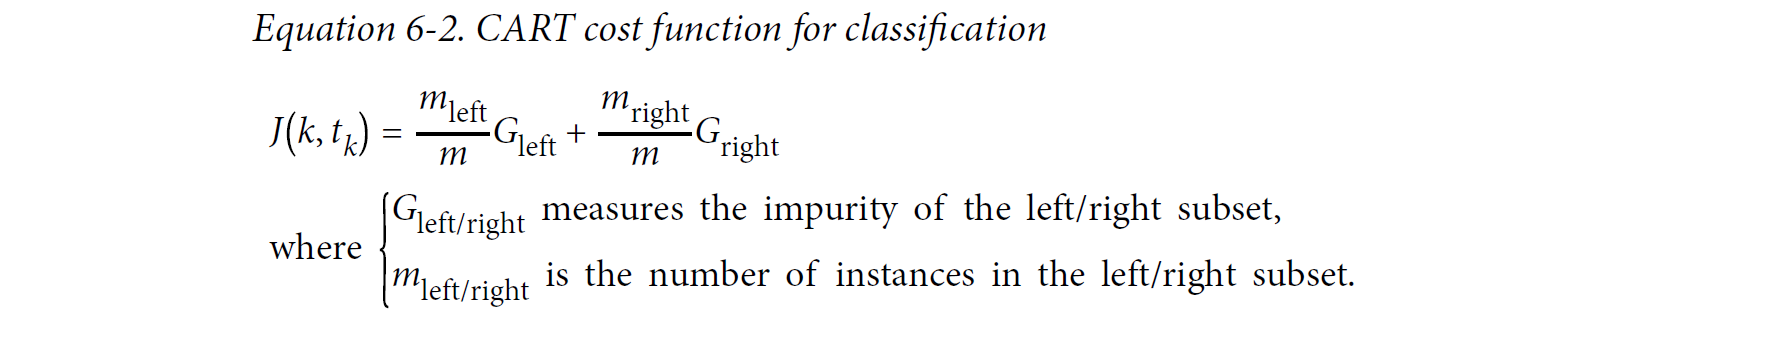

- Once it has successfully split the training set in two, it splits the subsets using the
same logic, then the sub-subsets and so on, recursively (it is a *greedy* algorithm). 
- It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity.
- A few other hyperparameters control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes`.

#### Gini or Entropy

By default, the Gini impurity measure is used, but you can select the entropy impurity
measure instead by setting the criterion hyperparameter to "entropy".

- A set's entropy is zero when it contains instances of only one class.

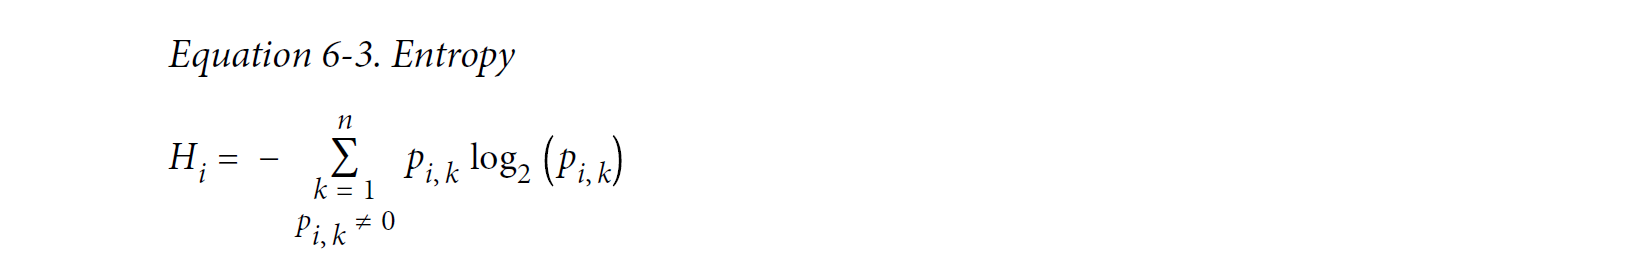



### Regularization Hyperparameters

- Decision Trees make very few assumptions about the training data (as opposed to linear models, which obviously assume that the data is linear, for example).
- If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, and most likely overfitting it.
- To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. This is called *regularization*.

1. Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.
2. `min_samples_split`: the minimum number of samples a node must have before it can be split.
3. `min_samples_leaf`: the minimum number of samples a leaf node must have.
4. `min_weight_fraction_leaf`: same as min_samples_leaf but expressed as a fraction of the total number of weighted instances.
5. `max_leaf_nodes`: maximum number of leaf nodes.
6. `max_features`: maximum number of features that are evaluated for splitting at each node.

#### Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.

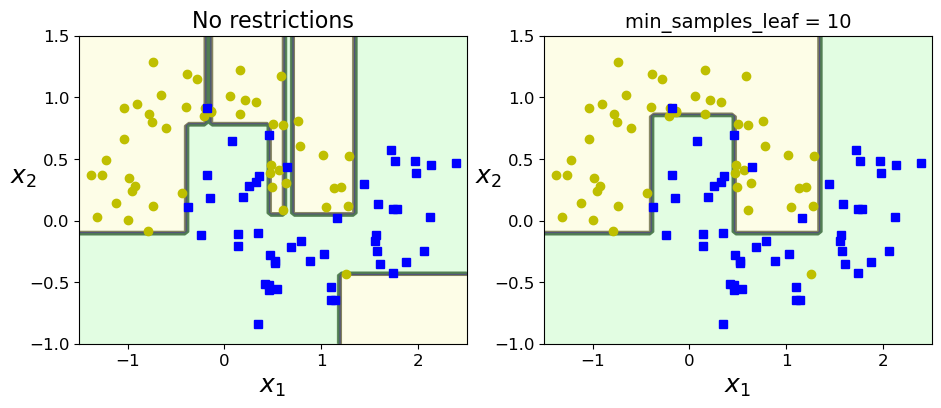

In [25]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

# Default vs. Regularized DTs
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4));
plt.subplot(121);
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False);
plt.title("No restrictions", fontsize=16);
plt.subplot(122);
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False);
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14);

plt.show();

It is quite obvious that the model on the left is overfitting, and the
model on the right will probably generalize better.

### Regression

Decision Trees are also capable of performing regression tasks.

Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with max_depth=2:

In [26]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [27]:
y.mean()

0.35386923462660264

In [28]:
np.square(y - y.mean()).mean()

0.09778938794576263

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
print(tree_reg.tree_.threshold)
print(tree_reg.tree_.value)


[ 0.19734927  0.09169627 -2.         -2.          0.77175754 -2.
 -2.        ]
[[[0.35386923]]

 [[0.68935686]]

 [[0.85389715]]

 [[0.55223996]]

 [[0.25924452]]

 [[0.11063973]]

 [[0.61460379]]]


In [31]:
tree_dot = export_graphviz(
        tree_reg,
        #out_file=os.path.join(IMAGES_PATH, "quad_tree.dot"),
        out_file=None,
        feature_names=['x1'],
        class_names=None,
        rounded=True,
        filled=True
    )

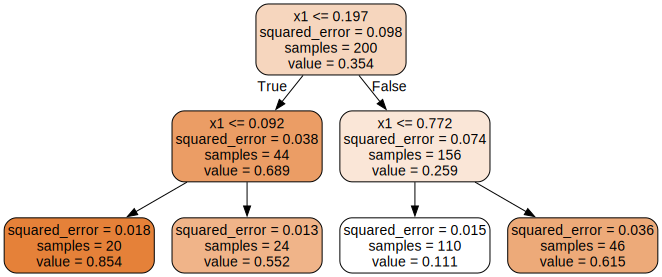

In [32]:
Source(tree_dot)

In [27]:
44/200 * .038 + 156/200 * 0.074

0.06608

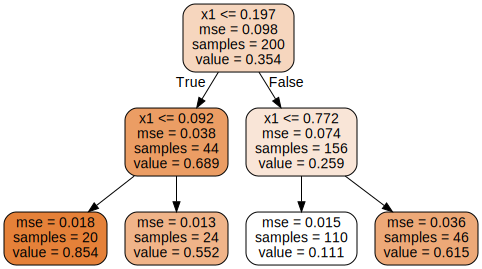

In [28]:
Source.from_file(os.path.join(IMAGES_PATH, "quad_tree.dot"))

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=3, random_state=42)

<Figure size 1100x400 with 0 Axes>

<Axes: >

Text(0.21, 0.65, 'Depth=0')

Text(0.01, 0.2, 'Depth=1')

Text(0.65, 0.8, 'Depth=1')

Text(0.5, 1.0, 'max_depth=2')

<Axes: >

Text(0.3, 0.5, 'Depth=2')

Text(0.5, 1.0, 'max_depth=3')

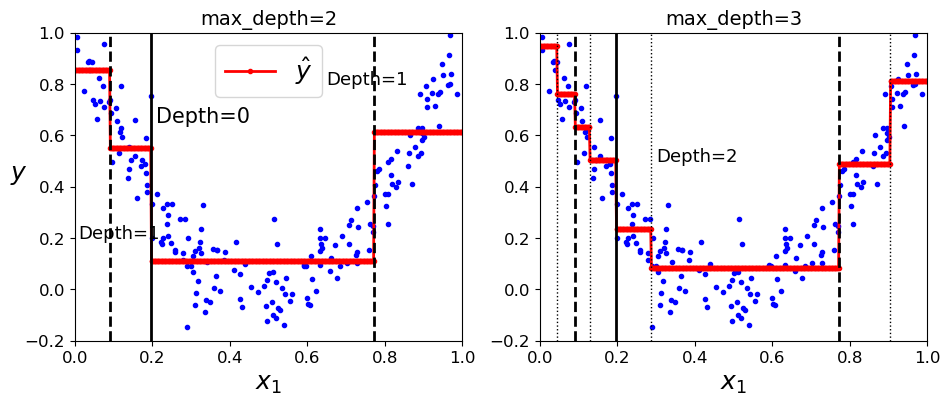

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

- Instead of predicting a class in each node, in this case the decision tree predicts a value.
- For example, suppose you want to make a prediction for a new instance with $x_1 = 0.6$. 
    - You traverse the tree starting at the root, and you eventually reach the leaf node that predicts $value=0.1106$.
    - This prediction is simply the average target value of the 110 training instances associated to this leaf node.
    - This prediction results in a Mean Squared Error (MSE) equal to 0.0151 over these 110 instances.

In [34]:
tree_reg1.tree_.threshold
tree_reg1.tree_.value
tree_reg1.tree_.impurity
tree_reg1.tree_.n_node_samples

array([ 0.19734927,  0.09169627, -2.        , -2.        ,  0.77175754,
       -2.        , -2.        ])

array([[[0.35386923]],

       [[0.68935686]],

       [[0.85389715]],

       [[0.55223996]],

       [[0.25924452]],

       [[0.11063973]],

       [[0.61460379]]])

array([0.09778939, 0.03767174, 0.0175742 , 0.01305739, 0.07404639,
       0.01512587, 0.03585498])

array([200,  44,  20,  24, 156, 110,  46], dtype=int64)

The **CART algorithm** works mostly the same way as earlier, except that instead of trying
to split the training set in a way that minimizes impurity, it now **tries to split the
training set in a way that minimizes the MSE**.

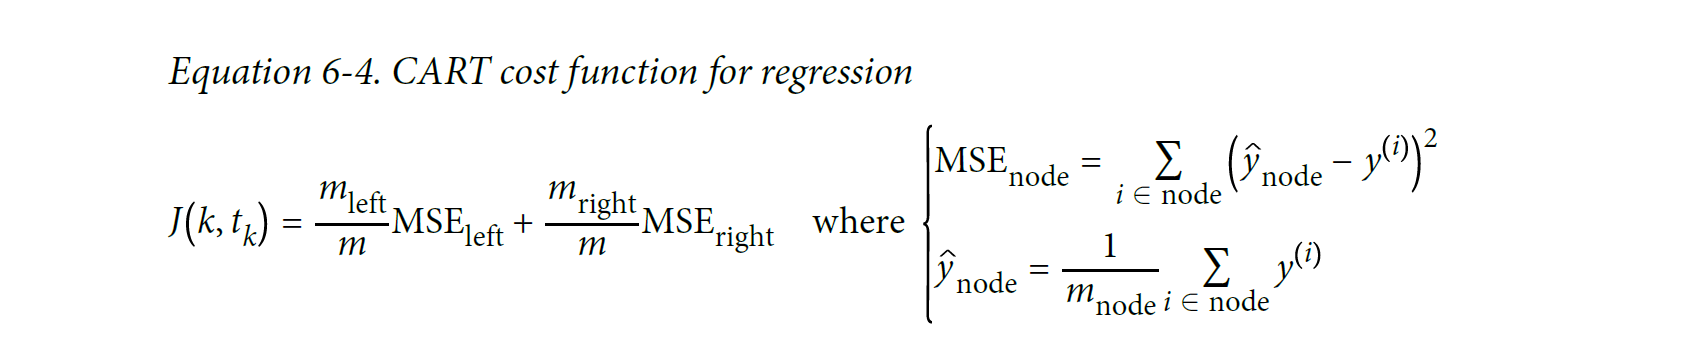

DecisionTreeRegressor(random_state=42)

DecisionTreeRegressor(min_samples_leaf=15, random_state=42)

<Figure size 792x288 with 0 Axes>

(0.0, 1.0, -0.2, 1.1)

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'No restrictions')

(0.0, 1.0, -0.2, 1.1)

Text(0.5, 0, '$x_1$')

Text(0.5, 1.0, 'min_samples_leaf=15')

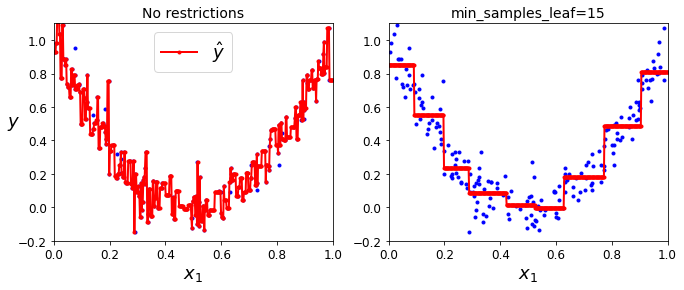

In [31]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=15)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

- Just like for classification tasks, Decision Trees are prone to overfitting when dealing
with regression tasks. 
- Without any regularization (i.e., using the default hyperparameters),
you get the predictions on the left of the figure. It is obviously overfitting
the training set very badly.
- Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right of the figure.

### Instability

- Decision Trees are simple to understand and interpret, easy to use, versatile, and powerful.
- However they do have a few limitations:
    - Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation.

DecisionTreeClassifier(random_state=42)

DecisionTreeClassifier(random_state=42)

<Figure size 792x288 with 0 Axes>

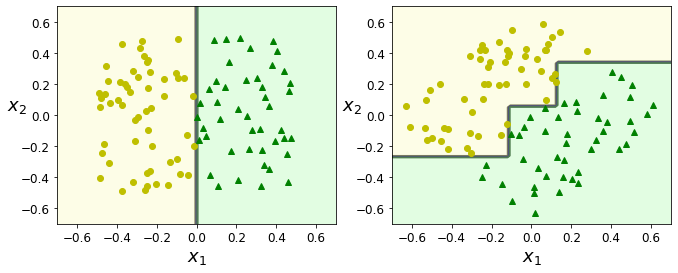

In [32]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

- The figure shows a simple linearly separable dataset:
- On the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted.
- Although both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well.
- One way to limit this problem is to use **PCA**, which often results in a better orientation of the training data.

- More generally, **the main issue with Decision Trees is that they are very sensitive to small variations in the training data**.
- For example, if you just remove the widest Iris-Versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, you may get the model represented in the figure below.


DecisionTreeClassifier(max_depth=2, random_state=42)

DecisionTreeClassifier(max_depth=2, random_state=40)

<Figure size 576x288 with 0 Axes>

Text(1.0, 0.9, 'Depth=0')

Text(1.0, 1.8, 'Depth=1')

Text(1.3, 1.0, 'Depth=0')

Text(3.1, 1.8, 'Depth=1')

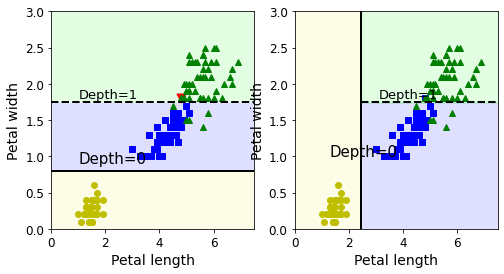

In [33]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)
plt.scatter([X[~not_widest_versicolor][0][0]], [X[~not_widest_versicolor][0][1]], 
            marker="v", color="red", s=80)

plt.subplot(122)
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.3, 1.0, "Depth=0", fontsize=15)
plt.text(3.1, 1.80, "Depth=1", fontsize=13)

plt.show()

- Actually, since the training algorithm used by Scikit-Learn is stochastic (it randomly selects the set of features to evaluate at each node) you may get very different models even on the same training data (unless you set the random_state hyperparameter).
- **Random Forests** can limit this instability by averaging predictions over many trees.